## 0)Setup

In [1]:
import os
os.getcwd()

'c:\\Users\\danie\\OneDrive\\Escritorio\\Data Science\\1. Python Projects\\mlflow_sandbox\\notebooks'

In [ ]:
import pandas as pd 
import mlflow
from mlflow.models import Model, infer_signature
import numpy as np 
import matplotlib.pyplot as plt
plt.style.use("ggplot")
import seaborn as sns
import optuna
import imblearn
from imblearn.over_sampling import BorderlineSMOTE
import shap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import (f1_score,
                             accuracy_score,
                             precision_score,
                             recall_score,
                             classification_report,
                             confusion_matrix
                            )
from lightgbm import LGBMClassifier, log_evaluation, early_stopping,record_evaluation
import sys
sys.path.insert(0, "../utils")
from utils import to_labels, plot_confusion_matrix

import warnings
warnings.filterwarnings("ignore")

In [3]:
os.path.dirname(os.getcwd())

'c:\\Users\\danie\\OneDrive\\Escritorio\\Data Science\\1. Python Projects\\mlflow_sandbox'

In [4]:
data_dir = "../data/raw"
model_dir = "../models"
reports_dir = "../reports"

### 1)Load Data

In [5]:
train_file = "train.feather"
test_file = "test.feather"

In [6]:
train = pd.read_feather(os.path.join(data_dir, train_file))
test = pd.read_feather(os.path.join(data_dir, test_file))

In [7]:
train.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,61848.0,-6.493504,-7.916078,1.766599,3.691802,8.601778,-5.285099,-5.093447,0.681439,-0.327785,...,0.784551,-0.085752,1.304263,-0.233903,0.963243,0.056030,-0.200075,0.250360,35.00,0
1,137724.0,2.148813,-0.074116,-2.573260,-0.337782,1.000894,-0.596484,0.502468,-0.201749,0.256163,...,0.126097,0.365870,-0.086476,-0.105702,0.457918,0.247134,-0.104046,-0.094673,1.89,0
2,38779.0,1.214958,0.085191,-0.210376,1.084983,0.504175,0.628632,0.066488,0.072260,0.395040,...,-0.179553,-0.333495,-0.256230,-1.308241,0.838409,-0.228402,0.032831,0.006043,33.43,0
3,146602.0,1.982180,-0.471654,-2.200225,-0.513788,1.962852,3.656344,-1.197833,1.021124,0.970691,...,0.178298,0.622512,0.141426,0.667823,-0.177522,0.663821,0.010158,-0.029923,5.40,0
4,54532.0,1.449681,-0.394615,-0.175006,-0.686506,-0.649152,-0.977233,-0.190287,-0.288279,-0.955334,...,-0.481098,-0.920193,-0.007627,-0.099904,0.368140,1.042930,-0.079473,-0.004652,9.00,0


In [8]:
train.shape

(227845, 31)

In [9]:
test.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,79680.0,0.072884,1.906549,-1.123671,1.180339,0.982895,-1.282922,0.374382,-1.848341,-0.922512,...,1.435803,-0.734119,-0.200428,0.209109,0.759462,-0.354700,0.277330,0.342436,0.89,0
1,166220.0,-0.239676,1.182107,-0.954990,-0.708438,0.826872,-0.280183,0.588853,0.474327,-0.481798,...,-0.261750,-0.800380,0.132014,0.092269,-0.353179,0.123095,0.086471,0.008750,24.98,0
2,79461.0,-0.381912,0.962363,1.100900,-0.419900,0.579052,0.089269,0.576797,0.149084,-0.593799,...,-0.250622,-0.687159,-0.178411,-0.853501,-0.063541,0.125720,0.260444,0.099496,2.58,0
3,16048.0,-1.006068,0.906788,0.958097,-1.535553,0.313330,-0.154731,0.343664,0.014661,2.228814,...,-0.461989,-0.735880,-0.074931,-0.922726,-0.065290,0.734702,0.287978,0.020499,6.15,0
4,150259.0,-0.832252,0.731328,1.102492,-0.873907,1.143540,0.661445,1.032933,0.254026,-0.511328,...,-0.151238,-0.356741,-0.219238,-1.028440,0.374073,0.496701,-0.006605,0.027265,26.12,0


In [10]:
test.shape

(56962, 31)

### 2)EDA

In [11]:
train["Class"].value_counts(normalize=True)

Class
0    0.998275
1    0.001725
Name: proportion, dtype: float64

In [12]:
test["Class"].value_counts(normalize=True)

Class
0    0.998262
1    0.001738
Name: proportion, dtype: float64

### 3)MLFLow

#### 3.1)Experiment Setup

In [23]:
# Track on localhost --> ./mlruns
mlflow_dir = "file:\\" + os.path.join(os.path.dirname(os.getcwd()), "mlruns")
exp_name = "Creditcard_Fraud_Detection"
model_name = "creditcard_model"
mlflow_dir

'file:\\c:\\Users\\danie\\OneDrive\\Escritorio\\Data Science\\1. Python Projects\\mlflow_sandbox\\mlruns'

In [24]:
#MLFlow Setup: https://www.mlflow.org/docs/latest/tracking.html#scenario-1-mlflow-on-localhost
mlflow.set_tracking_uri(mlflow_dir)

In [25]:
mlflow.get_tracking_uri()

'file:\\c:\\Users\\danie\\OneDrive\\Escritorio\\Data Science\\1. Python Projects\\mlflow_sandbox\\mlruns'

In [26]:
#Tracking uri must be set first with mlflow.set_tracking_uri()
client = mlflow.tracking.MlflowClient()

In [27]:
# #Delete existing experiment and registered model
# client.delete_experiment(client.get_experiment_by_name(exp_name).experiment_id)
# client.delete_registered_model(name=model_name)

In [28]:
# Create experiment if not exists
if client.get_experiment_by_name(exp_name) == None:
    experiment_id = client.create_experiment(exp_name)
else:
    experiment = client.get_experiment_by_name(exp_name)
    experiment_id = experiment.experiment_id

print(experiment_id)

208765272832732162


#### 3.2)Experiment Tracking

In [31]:
def objective(trial,
              X = train.drop(columns=["Time","Class"]).columns,
              y = "Class",
              labels = ["non-fraud", "fraud"],
              cv = 3,
              print_metrics = False,
              optimize_metric = "f1",
              val_size = .2
             ):
    
    # ============================== HYPERPARAMETER SPACE ==============================

    params = {
            #Static Hyperparameters
             'objective' : 'binary',
             'n_jobs': -1,
            #Hyperparameter Ranges
            'n_estimators': trial.suggest_int('n_estimators', 300 , 500),
            'num_iterations': trial.suggest_int('num_iterations', 100 , 500),
            'learning_rate': trial.suggest_float('learning_rate', .1, .5), 
            'reg_lambda': trial.suggest_float('reg_lambda', .5 , 10, log=True),
            'max_depth': trial.suggest_int('max_depth', 10, 15),
            'min_child_weight':trial.suggest_float('min_child_weight', 1 , 100)
        }  

    # ============================== CROSS VALIDATION ==============================

    f1_all=[]
    recall_all = []
    precision_all = []
    accuracy_all = []
    for i in range(cv):
        X_train, X_val, y_train, y_val = train_test_split(train[X],
                                                          train[y],
                                                          test_size=val_size
                                                          )
        #Scale Data
        scaler = MinMaxScaler()
        X_train = pd.DataFrame(scaler.fit_transform(X_train),
                               columns = X
                               )
        X_val = pd.DataFrame(scaler.transform(X_val),
                             columns= X 
                             )
        X_test = pd.DataFrame(scaler.transform(test[X]),
                              columns = X 
                             )      
        #Synthetic Data
        sm= BorderlineSMOTE(kind="borderline-1")
        X_train, y_train=sm.fit_resample(X_train, y_train)
        #Model     
        model=LGBMClassifier(**(params))
        model.fit(X_train,
                  y_train,
                  callbacks=[log_evaluation(0)],
             )
        ##Predicted Probabilities
        preds_proba= model.predict_proba(X_val)[: ,1]
        ##Optimize Threshold
        thresholds = np.arange(0, 1, 0.1)
        f1_scores = [f1_score(y_val, to_labels(preds_proba, t)) for t in thresholds]
        f1_ix = np.argmax(f1_scores)
        preds= np.where(preds_proba>=thresholds[f1_ix] , 1, 0)
        ## Metrics
        f1 = f1_score(y_val, preds)
        recall = recall_score(y_val, preds)
        precision = precision_score(y_val, preds)
        accuracy = accuracy_score(y_val,preds)
        #Append Metrics
        f1_all.append(f1)
        recall_all.append(recall)
        precision_all.append(precision)
        accuracy_all.append(precision)
        if print_metrics:
            print(f"\nCV SPLIT:{i}\nMETRICS:\n\nf1 score: {f1}\nrecall: {recall}\nprecision: {precision}\nprecision: {accuracy}\n\n")

    metrics_dict = {
                    "cv_mean_f1": np.mean(f1_all),
                    "cv_mean_recall": np.mean(recall_all),
                    "cv_mean_precision": np.mean(precision_all),
                    "cv_mean_accuracy": np.mean(accuracy_all),
                    }

    selected_metric = metrics_dict[f"cv_mean_{optimize_metric}"]

    # ============================== WHOLE SAMPLE TRAINING AND MLFLOW LOGGING ==============================


    mlflow.lightgbm.autolog()

    #Manual logging
    with mlflow.start_run(experiment_id = experiment_id) as run:
        X_train, y_train  = train[X], train[y]
        X_test, y_test  = test[X], test[y]
        #Scale Data
        scaler = MinMaxScaler()
        X_train = pd.DataFrame(scaler.fit_transform(X_train),
                               columns = X 
                              )
        X_test = pd.DataFrame(scaler.transform(X_test),
                              columns = X 
                              ) 
        #Synthetic Data
        sm= BorderlineSMOTE(kind="borderline-1")
        X_train, y_train=sm.fit_resample(X_train, y_train)
        #Model
        eval_result = {}
        model=LGBMClassifier(**(params))
        model.fit(X_train,
                  y_train,
                  callbacks=[log_evaluation(0)],
                 )
        # Register metrics
        cv_f1s = [mlflow.log_metric(f'cv_{i}_f1', f1_all[i]) for i in range(cv)]
        cv_recalls = [mlflow.log_metric(f'cv_{i}_recall', recall_all[i]) for i in range(cv)]
        cv_precisions = [mlflow.log_metric(f'cv_{i}_precision', precision_all[i]) for i in range(cv)]
        cv_accuracies = [mlflow.log_metric(f'cv_{i}_accuracy', accuracy_all[i]) for i in range(cv)]
        cv_mean_metrics = [mlflow.log_metric(k,v) for k,v in metrics_dict.items()]
        # Create model signature
        preds = model.predict(X_train)
        signature = infer_signature(X_train, preds)
        #Register Model
        mlflow.lightgbm.log_model(model,
                                  artifact_path= "model",
                                  signature=signature
                                 )
        #Plot confusion matrix and shap values if this trial is the best
        best_metric = mlflow.search_runs(experiment_ids=[experiment_id],
                                    order_by=[f"metrics.cv_mean_{optimize_metric} DESC"],
                                    max_results=1
                                    )[f"metrics.cv_mean_{optimize_metric}"][0]
        if selected_metric >= best_metric:
            #Test Metrics
            ordered_cols = model.booster_.feature_name()
            # Predicted Probabilities
            preds_proba= model.predict_proba(X_test[ordered_cols])[: ,1]
            ##Optimize Threshold
            thresholds = np.arange(0, 1, 0.1)
            f1_scores = [f1_score(y_test, to_labels(preds_proba, t)) for t in thresholds]
            f1_ix = np.argmax(f1_scores)
            mlflow.log_metric(f'optimized_threshold',  thresholds[f1_ix])
            # Predicted labels
            preds= np.where(preds_proba>=thresholds[f1_ix] , 1, 0)
            #Confusion Matrix
            plot_confusion_matrix(y_test,
                                  preds,
                                  labels = labels,
                                  save=True,
                                  save_path = reports_dir
                                 )
            mlflow.log_artifact(os.path.join(reports_dir,"confusion_matrix.png"),
                                artifact_path= "test"
                                )
            class_report = pd.DataFrame(classification_report(y_test,
                                                              preds,
                                                              output_dict = True,
                                                              target_names= labels
                                                             )
                                        )
            mlflow.log_table(data=class_report,
                             artifact_file="test/classification_report.json"
                             )
            mlflow.log_metric(f'test_f1', f1_score(y_test,preds))
            mlflow.log_metric(f'test_recall', recall_score(y_test,preds))
            mlflow.log_metric(f'test_precision', precision_score(y_test,preds))
            mlflow.log_metric(f'test_accuracy', accuracy_score(y_test,preds))
            #Shap Values
            explainer = shap.TreeExplainer(model)
            shap_values = explainer.shap_values(X_train[ordered_cols])
            shap.summary_plot(shap_values[1], 
                                    X_train[ordered_cols],
                                    show=False
                                    )
            plt.savefig(os.path.join(reports_dir,"summary_plot.png"))
            plt.close()
            mlflow.log_artifact(os.path.join(reports_dir,"summary_plot.png"),
                                artifact_path= "shap_values"
                                )

            

    return selected_metric

In [ ]:
study = optuna.create_study(direction="maximize",
                           )
study.optimize(objective,
               timeout = 60*60*6,
               n_trials=25,
               gc_after_trial=True
              )

#### 3.3)Retrieve Best Model

MLflow utiliza un formato estándar para almacenar los modelos de ML. Esto permite, por ejemplo, entrenar un modelo en TensorFlow usando Keras, guardarlo, e importarlo desde cualquier servicio o plataform para su ejecución desde un entorno de Python u otro lenguaje de programación (con las dependencias que necesite).

Depdendiendo de donde se entrene disponemos de una serie de **flavors** compatibles. En este caso podemos usar **keras** y **python_function**.

In [38]:
optimize_metric = "f1"
runs =  mlflow.search_runs(experiment_ids=[experiment_id],
                               order_by=[f"metrics.cv_mean_{optimize_metric} DESC"],
                               max_results=1
                              )
best_run_id = runs.iloc[0]["run_id"]

In [39]:
#Retrieve best model uri
best_model_uri = f"runs:/{best_run_id}/model"
best_model_uri

'runs:/9120fd8f3cc14730ad8607e5f8d202d9/model'

En la carpeta `model` disponemos del fichero MLmodel que define los flavors disponibles.

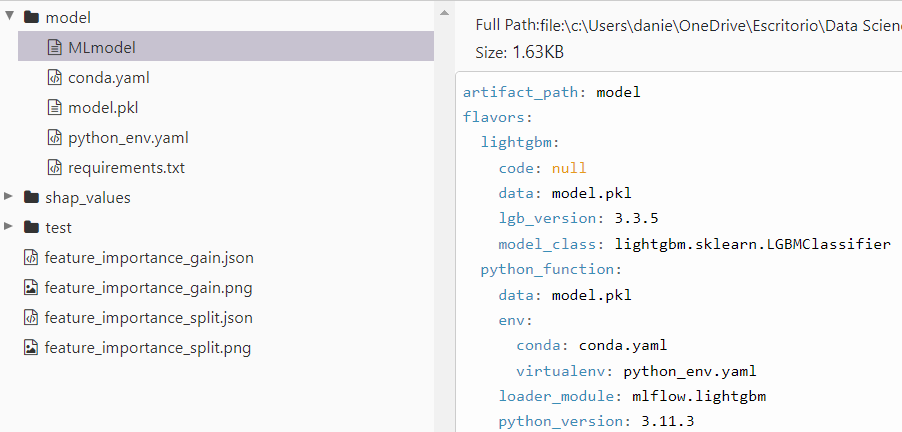

In [33]:
# Load model as a PyFuncModel.
# best_model = mlflow.pyfunc.load_model(model_uri = best_model_uri)


# Load model as a LGBMCLassifier
best_model = mlflow.lightgbm.load_model(model_uri = best_model_uri)

In [34]:
type(best_model)

lightgbm.sklearn.LGBMClassifier

In [35]:
#Prepare data for inference
X = train.drop(columns=["Time","Class"]).columns
y = "Class"
X_train, y_train  = train[X], train[y]
X_test, y_test  = test[X], test[y]


scaler = MinMaxScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train),
                        columns = X 
                        )
X_test = pd.DataFrame(scaler.transform(X_test),
                        columns = X 
                        ) 

In [36]:
#Predict
best_model.predict(X_test)

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [ ]:
type(model)

Si quisieramos buscar todos los modelos que tenemos registrados podríamos hacerlo de la siguiente forma.

In [37]:
registered_models = client.search_registered_models()

for rm in registered_models:
    print(rm.name)

creditcard_model


#### 3.4)Model Staging

Podemos establecer cuando un modelo es desplegado en producción con los stages, estos pueden ser:

- `Staging`: desarrollo/pre-producción antes de ser desplegado a producción.
- `Production`: producción despues de ser testeado.

Estas etapas son simbólicas y sirven para cargar directamente el model registrado en producción y de esta forma que no haya errores en las apliación o softwares donde se quieran utilizar.

In [48]:
# Register best model
best_model = mlflow.register_model(
                                    best_model_uri,
                                    model_name
                    )

Successfully registered model 'creditcard_model'.
2023/06/27 15:12:53 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: creditcard_model, version 1
Created version '1' of model 'creditcard_model'.


In [ ]:
#Staging
# model_staging = client.transition_model_version_stage(
#                                                     name=model_name,
#                                                     version=best_model.version,
#                                                     stage="Staging"
#                                                     )

In [53]:
#Production
model_prod = client.transition_model_version_stage(
                                                    name=model_name,
                                                    version=best_model.version,
                                                    stage="Production"
                                                  )

In [54]:
#Retrieve model in production
prod_model = mlflow.lightgbm.load_model(model_uri=f"models:/{model_name}/Production")

##### Extra:LightGBM documentation

https://mlflow.org/docs/latest/python_api/mlflow.lightgbm.html#mlflow.lightgbm.autolog

